In [2]:
# imports
import yaml
from typing import List, Dict, Tuple, TypeVar, Any
import numpy as np
from numpy.typing import NDArray
from queue import Queue
import matplotlib.pyplot as plt
import random as rand
import time

In [3]:
# Enter world here
with open('worlds.yml', 'r') as f:
  worlds = yaml.safe_load(f)

world = worlds['world_1']

grid_2d = np.array(world['grid'])
grid = grid_2d[np.newaxis, :, :]

agent_start = np.array(world['agent_start'])[0]

grid = np.repeat(grid, 8, axis=0)

grid_height = grid.shape[1]
grid_width = grid.shape[2]
agent_position = agent_start

In [4]:

# def plot_simulation(agent_traj = , ):
#     # simulation
#     grid_height = grid.shape[1]
#     grid_width = grid.shape[2]
#     agent_position = agent_start

#     #TODO update outside instead of using dummy
#     agent_trajectory = [
#         (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)
#     ]

#     fig, ax = plt.subplots()

#     # plot grid
#     for y in range(grid_height):
#         for x in range(grid_width):
#             if grid_2d[y, x] == 0:
#                 color = 'white'
#             elif grid_2d[y, x] == 1:
#                 color = 'red'
#             else:
#                 color = 'green'
#             rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
#             ax.add_patch(rect)

#     # plot path
#     x_coords = [pos[0] + 0.5 for pos in agent_trajectory]
#     y_coords = [pos[1] + 0.5 for pos in agent_trajectory]
#     ax.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=3)


#     # plot agebt;s initial position
#     ax.plot(agent_position[0] + 0.5, agent_position[1] + 0.5, marker='o', markersize=8, color='red', label='Start')

#     # plot attributes
#     plt.title('Grid World Simulation')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.xlim(0, grid_width)
#     plt.ylim(0, grid_height)
#     plt.xticks(range(0, grid_width, 1))
#     plt.yticks(range(0, grid_height, 1)) 
#     plt.gca().invert_yaxis()  
#     plt.grid(visible=True)
#     plt.legend()

#     plt.show()


In [5]:
# world_table = np.zeros((8, grid_height, grid_width), dtype=object)
# Handle everything related to graph search
class Node:
    def __init__(self, theta: int, y: int, x: int):
        self.x = x
        self.y = y
        self.theta = theta
        self.in_gf = False
        self.in_gb = False
        self.gf_parent = None
        self.gf_children = []
        self.gb_parent = None
        self.gb_children = []

    def __eq__(self, other: 'Node'):
        return self.x == other.x and self.y == other.y and self.theta == other.theta
    
    def __hash__(self):
        return hash((self.x, self.y, self.theta))
    
    def __str__(self):
        return f'Node: {self.theta}, {self.y}, {self.x}\n  in gf: {self.in_gf}\n  in gb: {self.in_gb}'


    # gets the children when searching for connection to GF. This means that 
    # these 'children' are actually potential parents, and are gotten using the
    # inverse dynamics
    def get_reverse_children(self, world_table: NDArray, 
                         this_grid_width=grid_width, 
                         this_grid_height=grid_height) -> List['Node']:
        
        children = []
        # ugly workaround to get the x-y coordinates of the potential parents
        child_x = self.x
        child_y = self.y
        if self.theta == 0:
            child_y += 1
        if self.theta == 1:
            child_x -= 1
            child_y += 1
        if self.theta == 2:
            child_x -= 1
        if self.theta == 3:
            child_x -= 1
            child_y -= 1
        if self.theta == 4:
            child_y -= 1
        if self.theta == 5:
            child_x += 1
            child_y -= 1
        if self.theta == 6:
            child_x += 1
        if self.theta == 7:
            child_x += 1
            child_y += 1

        # check if the potential parent is not in the world
        if    (child_x < 0 or child_x >= this_grid_width 
            or child_y < 0 or child_y >= this_grid_height):
            return children

        for i in range(self.theta - 1, self.theta + 2):
            theta_index = i % 8
            children.append(world_table[theta_index, child_y, child_x])
        return children
    
    # gets the children when searching for connection to GB. This searches for
    # true forward children, and is gotten using the forward dynamics
    def get_forward_children(self, world_table: NDArray,
                                this_grid_width=grid_width,
                                this_grid_height=grid_height) -> List['Node']:
            children = []
            # ugly workaround to get the x-y coordinates of the potential parents
            for i in range(self.theta - 1, self.theta + 2):
                child_x = self.x
                child_y = self.y
                theta_index = i % 8
                if theta_index == 0:
                    child_y -= 1
                if theta_index == 1:
                    child_x += 1
                    child_y -= 1
                if theta_index == 2:
                    child_x += 1
                if theta_index == 3:
                    child_x += 1
                    child_y += 1
                if theta_index == 4:
                    child_y += 1
                if theta_index == 5:
                    child_x -= 1
                    child_y += 1
                if theta_index == 6:
                    child_x -= 1
                if theta_index == 7:
                    child_x -= 1
                    child_y -= 1
                if    (child_x < 0 or child_x >= this_grid_width
                    or child_y < 0 or child_y >= this_grid_height):
                    continue
                children.append(world_table[theta_index, child_y, child_x])
            return children

# BFS
# criteria:
#   'gf': try to connect to GF
#   'gb': try to connect to GB
# returns: the node that is connected to GF, or None if no connection is found
def bfs(start: Node, goal_set: List[Node], criteria: str, world_table: NDArray, this_grid=grid_2d) -> Node:
    parents_dict = {}
    parents_dict[start] = None
    children = None
    q = Queue()
    q.put(start)
    curr_node = None
    iteration = 0
    # while not q.empty():
    while True:
        try:
            curr_node = q.get(block=False)
        except:
            break
        # print('='*20)
        # print(f'Iteration {iteration}')
        # print(f'curr_node tyx: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        iteration += 1
        assert type(curr_node) == Node
        if curr_node in goal_set:
            break
        if criteria == 'gf':
            if curr_node.in_gf:
                break
            children = curr_node.get_reverse_children(world_table, 
                                                  this_grid_width=this_grid.shape[1], 
                                                  this_grid_height=this_grid.shape[0])
        if criteria == 'gb':
            if curr_node.in_gb:
                break
            children = curr_node.get_forward_children(world_table,
                                                    this_grid_width=this_grid.shape[1],
                                                    this_grid_height=this_grid.shape[0])
        for child in children:
            # TODO:change logic to use grid_2d
            # grid_2d[child.y, child.x] == 0 means unobstructed
            # grid_2d[child.y, child.x] == 1 means obstructed
            # print(f'Considering child tyx: {child.theta}, {child.y}, {child.x}')
            # print(f'grid: {this_grid[child.y, child.x]}')
            if this_grid[child.y, child.x] == 0 and not child in parents_dict:
                # child.bfs_parent = curr_node
                parents_dict[child] = curr_node
                q.put(child)
                # print(f'\tChild added: {child.theta}, {child.y}, {child.x}')

    # failure cases
    if curr_node is None:
        # print('No connection found')
        return None
    if criteria == 'gf':
        if not curr_node.in_gf:
            # print('No connection to GF found')
            return None
    if criteria == 'gb':
        if not curr_node.in_gb:
            # print('No connection to GB found')
            return None

    # backtrack to connect GF
    winner = curr_node
    while curr_node in parents_dict:
        next_node = parents_dict[curr_node]
        if criteria == 'gf':
            curr_node.in_gf = True
            if next_node is None:
                break
            curr_node.gf_children.append(next_node)
            next_node.gf_parent = curr_node
        if criteria == 'gb':
            curr_node.in_gb = True
            if next_node is None:
                break
            curr_node.gb_children.append(next_node)
            next_node.gb_parent = curr_node
        # print(f'Just marked this node in GF: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        curr_node = next_node
    # last cleanup step for GB
    # if criteria == 'gb':
    #     connect_gf_gb(start)
    return winner

# Take points in GF and connect them in GB if possible
# TODO: still need to call this from BFS!!!! But only after rest of simulator set up
def connect_gf_gb(start):
    assert start.in_gb == True, 'tried to connect gf to gb without starting in gb'
    assert start.in_gf == True, 'tried to connect gf to gb without starting in gf'

    # iterate through gf parents, adding them to gb. This always results in a 
    # cycle through home, so we can check while not in gb
    curr_node = start
    next_node = curr_node.gf_parent
    while not next_node.in_gb:
        if next_node is None:
            print('SOMETHING WRONG WITH GF PARENTS')
            break
        next_node.in_gb = True
        next_node.gb_parent = curr_node
        curr_node.gb_children.append(next_node)
        curr_node = next_node
        next_node = curr_node.gf_parent
    next_node.gb_parent = curr_node


# Test the get_reverse_children function, world is a 3D array: theta, y, x
def test_get_reverse_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
    start = world[0, 0, 0]
    children = start.get_reverse_children(world)
    assert len(children) == 3
    assert children[0] == world[7, 1, 0]
    assert children[1] == world[0, 1, 0]
    assert children[2] == world[1, 1, 0]

    start = world[3, 0, 0]
    children = start.get_reverse_children(world)
    assert len(children) == 0

    start = world[2, 0, 1]
    children = start.get_reverse_children(world)
    assert len(children) == 3
    assert children[0] == world[1, 0, 0]
    assert children[1] == world[2, 0, 0]
    assert children[2] == world[3, 0, 0]

def test_get_forward_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 0

    start = world[0, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 2

    start = world[0, 1, 1]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 3

    start = world[7, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 1

def test_bfs():
    world = np.zeros((8, 5, 5), dtype=Node)
    this_grid = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    goal_to_find = world[0, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 0]
    assert start.gf_parent.gf_parent == world[0, 2, 0]
    assert start.in_gf == True

    start = world[7, 0, 0]
    goal_to_find = world[0, 2, 1]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 1]
    assert start.gf_parent.gf_parent == world[0, 2, 1]
    assert start.in_gf == True


    start = world[0, 4, 4]
    goal_to_find = world[7, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == None


    # start = world[0, 0, 0]
    # goal_to_find = world[0, 2, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal is None
    # assert start.in_gb == False

    # start = world[0, 1, 0]
    # goal_to_find = world[0, 0, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal == goal_to_find
    # assert start.gb_parent == world[0, 0, 0]
    # assert start.gb_parent.gb_parent == None
    # assert start.in_gb == True

    start = world[1, 4, 4]
    goal_set = []
    for i in range(3):
        goal_set.append(world[0, 0, 4-i])
        goal_set[i].in_gb = True
    goal = bfs(start, goal_set, 'gb', world, this_grid)
    assert start.in_gb == True
    # print(f'Start: {start}')
    # print(start.gb_parent)
    # print(start.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent.gb_parent)

def test_connect_gf_gb():
    nodes = []
    for i in range(8):
        new_node = Node(i, 0, 0)
        new_node.visible = True
        new_node.in_gf = True
        nodes.append(new_node)
    nodes[0].in_gb = True
    nodes[7].in_gb = True
    for i in range(7):
        nodes[i].gf_parent = nodes[i+1]
        nodes[i+1].gf_children.append(nodes[i])

    connect_gf_gb(nodes[0])
    assert nodes[6].gb_parent == nodes[5]
    assert nodes[7].gb_parent == nodes[6]

test_get_reverse_children()
test_get_forward_children()
test_bfs()
test_connect_gf_gb()


# How to use Agent
- Initialize an agent with home and goal node
- EXPLORE
  - tup = agent.sample_for_gf()
  - agent.attempt_add_node_to_gf(tup)
    - Do this a few times to get a few points
  - tup, i = agent.sample_for_gb()
  - agent.attempt_add_node_to_gb(tup, i)
    - Do this a few times to get a few points
- Then call agent.move()
  - This will compute a trajectory if needed, move the agent one step in the trajectory, and compute the sensor update (mark points visible/obstructed for the agent)

In [11]:
class Agent:
    def __init__(self, home: Node, goal: Node, world_table: NDArray):
        self.home = home
        self.goal = goal
        self.path_to_goal_exists = False
        self.pose = (home.x, home.y)
        self.world_table = world_table
        # trajectory: list of tuples (x, y), starting and ending at home
        self.trajectory = []
        self.trajectory_index = 0
        self.trajectory_complete = True
        self.sensor_radius = 5

        # -1 if (y, x) is not visible, 0 if it is visible and free, 1 if it is visible and obstructed
        self.visible_positions = -1*np.ones((grid_height, grid_width))
        self.goal_visible = False
        self.compute_sensor_update(grid_2d)

        # list of (theta, y, x) tuples that are in GF but not GB
        self.gf_cut_gb = []

        # list of (theta, y, x) tuples that are in GB and unvisisted
        self.unvisited_gb = []

        #TODO: temp counter to plot every _ iterations
        self.plot_tick = 0


    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # returns true if successful, false if not
    def move(self, this_grid=grid_2d):

        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # move to next position in trajectory
        self.trajectory_index += 1
        self.pose = self.trajectory[self.trajectory_index]
        self.compute_sensor_update(this_grid)
        
        # # plot iteration
        # self.plot_tick += 1
        # if self.plot_tick % 1000 == 0:
        #     self.plot_iteration()

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Compute a trajectory from the current pose to the home pose by following
    # a cycle in GB, passing through an unexplored point in GB
    def compute_trajectory(self):
        index = rand.randint(0, len(self.unvisited_gb) - 1)
        coord = self.unvisited_gb.pop(index)
        theta, y, x = coord

        if self.path_to_goal_exists:
            theta, y, x = self.goal.theta, self.goal.y, self.goal.x

        # following gf_parents from coord to home gets the beginning of the trajectory in reverse
        # following gb_parents from coord to home gets the end of the trajectory
        first_half = []
        curr_node = self.world_table[theta, y, x]
        while curr_node != self.home:
            first_half.append((curr_node.x, curr_node.y))
            if curr_node.gf_parent is None:
                print('Something wrong with gf parent')
                print(f'first half: {first_half}')
                print(f'curr_node: {curr_node}')
                print(f'Goal: {self.goal}')
            curr_node = curr_node.gf_parent
        first_half.append((self.home.x, self.home.y))
        first_half.reverse()
        self.trajectory = first_half
        if self.path_to_goal_exists:
            return
        curr_node = self.world_table[theta, y, x].gb_parent
        while curr_node != self.home:
            self.trajectory.append((curr_node.x, curr_node.y))
            curr_node = curr_node.gb_parent
        self.trajectory.append((self.home.x, self.home.y))

    # Sample a point to add to GF
    # returns (theta, y, x) tuple that is a candidate for addition to GF
    def sample_for_gf(self) -> Tuple[int, int, int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x)
        theta_order = [0, 1, 2, 3, 4, 5, 6, 7]
        for _ in range(1000):
            x = rand.randint(0, grid_width - 1)
            y = rand.randint(0, grid_height - 1)
            if self.visible_positions[y, x] == 0:
                rand.shuffle(theta_order)
                for theta in theta_order:
                    if not self.world_table[theta, y, x].in_gf:
                        return (theta, y, x)

    # try to add a node to GF from (theta, y, x) tuple
    def attempt_add_node_to_gf(self, coord: Tuple[int, int, int]) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gf', 
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            self.gf_cut_gb.append(coord)
        # else:
            # print(f'Failed to add node to GF: {coord}')
        return success is not None
    
    # sample a point to add to GB
    # returns ((theta, y, x), index) tuple that is a candidate for addition to GB, and index into gf_cut_gb
    def sample_for_gb(self) -> Tuple[Tuple[int, int, int], int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x), 0
        if len(self.gf_cut_gb) == 0:
            return None, None
        index = rand.randint(0, len(self.gf_cut_gb) - 1)
        return self.gf_cut_gb[index], index
    
    # try to add a node to GB from (theta, y, x) tuple
    def attempt_add_node_to_gb(self, coord: Tuple[int, int, int], index: int) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home, self.goal]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gb',
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            self.gf_cut_gb.pop(index)
            self.unvisited_gb.append(coord)
            if success == self.goal:
                self.path_to_goal_exists = True
        return success is not None



    # Compute sensor update, marking points visible and obstructed as necessary
    # modifies self.visible_positions
    def compute_sensor_update(self, this_grid=grid_2d):
        # iterate over all points in the sensor range
        for y in range(-self.sensor_radius, self.sensor_radius):
            for x in range(-self.sensor_radius, self.sensor_radius):
                # check if the point is in the grid
                if (self.pose[0] + x < 0 or self.pose[0] + x >= grid_width
                    or self.pose[1] + y < 0 or self.pose[1] + y >= grid_height):
                    continue
                # check if the point is visible or obstructed
                if this_grid[self.pose[1] + y, self.pose[0] + x] == 1:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 1
                else:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 0
                    # print(f'Now visible: {self.pose[1] + y}, {self.pose[0] + x}')
        # check if the goal is visible
        if self.visible_positions[self.goal.y, self.goal.x] == 0:
            self.goal_visible = True

    def plot_iteration(self):
        # simulation
        fig, ax = plt.subplots()

        # plot grid
        for y in range(grid_height):
            for x in range(grid_width):
                if grid_2d[y, x] == 0:
                    color = 'white'
                elif grid_2d[y, x] == 1:
                    color = 'red'
                else:
                    color = 'green'
                rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
                ax.add_patch(rect)

        # plot path
        x_coords = [pos[0] + 0.5 for pos in self.trajectory]
        y_coords = [pos[1] + 0.5 for pos in self.trajectory]
        ax.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=3)

        # plot agent's position - circle
        circle = plt.Circle((self.pose[0] + 0.5, self.pose[1] + 0.5), 0.3, color='red', label='Agent pose')
        ax.add_patch(circle)

        # create triangle
        triangle_coords = np.array([
            [self.pose[0] + 0.5, self.pose[1] + 0.8],  # Top
            [self.pose[0] + 0.35, self.pose[1] + 0.5],  # Bottom left
            [self.pose[0] + 0.65, self.pose[1] + 0.5],  # Bottom right
            [self.pose[0] + 0.5, self.pose[1] + 0.8]  # Back to top to close the shape
        ])

        # Plot the triangle
        triangle = plt.Polygon(triangle_coords, closed=True, color='blue')
        ax.add_patch(triangle)

        # plot attributes
        plt.title('Grid World Simulation')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.xlim(0, grid_width)
        plt.ylim(0, grid_height)
        plt.xticks(range(0, grid_width, 1))
        plt.yticks(range(0, grid_height, 1))
        plt.gca().invert_yaxis()
        plt.grid(visible=True)
        plt.legend()

        plt.show()

In [7]:
def get_reverse_state(state: Node, world_table: NDArray) -> Node:
    return world_table[(state.theta + 4) % 8, state.y, state.x]

# get resultant theta from two consecutive positions
# poses are tuples (x, y)
def get_theta_from_poses(pose1: Tuple[int, int], pose2: Tuple[int, int]) -> int:
    x1, y1 = pose1
    x2, y2 = pose2
    if x2 > x1:
        if y2 > y1:
            return 3
        elif y2 == y1:
            return 2
        else:
            return 1
    elif x2 == x1:
        if y2 > y1:
            return 4
        else:
            return 0
    else:
        if y2 > y1:
            return 5
        elif y2 == y1:
            return 6
        else:
            return 7

def get_potential_next_states(pose: List[Tuple[int, int]], theta: int) -> List[Tuple[int, int]]:
    x, y = pose
    if theta == 0:
        return [(x, y-1), (x+1, y-1), (x-1, y-1)]
    if theta == 1:
        return [((x, y-1), (x+1, y-1), (x+1, y))]
    if theta == 2:  
        return [(x+1, y-1), (x+1, y), (x+1, y+1)]
    if theta == 3:
        return [(x+1, y), (x+1, y+1), (x, y+1)]
    if theta == 4:
        return [(x+1, y+1), (x, y+1), (x-1, y+1)]
    if theta == 5:
        return [(x, y+1), (x-1, y+1), (x-1, y)]
    if theta == 6:
        return [(x-1, y+1), (x-1, y), (x-1, y-1)]
    if theta == 7:
        return [(x-1, y), (x-1, y-1), (x, y-1)]

# Receding horizon agent class
class AgentRH(Agent):
    def __init__(self, home: Node, goal: Node, world_table: NDArray, alpha: float=0.9):
        super().__init__(home, goal, world_table)

        self.theta = self.home.theta

        # check if it is possible to do receding horizon
        self.receding_horizon_possible = False
        if self.compute_safe_turnaround(get_reverse_state(home)) is not None:
            self.receding_horizon_possible = True

        self.in_receding_horizon_mode = False
        self.receding_horizon_trajectory = []
        self.alpha = alpha

    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # takes a receding horizon trajectory with probability alpha, if it exists
    # returns true if successful, false if not
    def move(self, this_grid=grid_2d):
        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # transition to receding horizon mode when we are halfway through a 
        # trajectory, if possible
        # TODO: right now this is going to result in a lot of receding horizon
        # (i.e. even on the way back to the home state), but it will do for now
        if self.trajectory_index == len(self.trajectory) // 2:
            self.in_receding_horizon_mode = self.receding_horizon_possible

        # if in receding horizon mode, try to take a receding horizon trajectory
        # accept as the new trajectory with probability alpha
        if self.in_receding_horizon_mode:
            success = self.compute_receding_horizon_trajectory()
            if success and rand.random() < self.alpha:
                self.trajectory = self.receding_horizon_trajectory
                self.trajectory_index = 0
                self.trajectory_complete = False
                self.in_receding_horizon_mode = True
                # print('Took receding horizon trajectory')
            else:
                self.in_receding_horizon_mode = False
                # print('Did not take receding horizon trajectory')


        # move to next position in trajectory
        self.trajectory_index += 1
        next_pose = self.trajectory[self.trajectory_index]
        self.theta = get_theta_from_poses(self.pose,  next_pose)
        self.pose = next_pose
        self.compute_sensor_update(this_grid)

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Attempt to compute a receding horizon trajectory
    # returns true if successful, false if not
    def compute_receding_horizon_trajectory(self):
        if not self.receding_horizon_possible:
            return False
        # uniformly get one of the three potential next states based on theta
        potential_next_states = get_potential_next_states(self.pose, self.theta)
        # shuffle
        rand.shuffle(potential_next_states)
        for state in potential_next_states:
            # make sure in the map
            if (state[0] < 0 or state[0] >= grid_width
                or state[1] < 0 or state[1] >= grid_height):
                continue
            # try to compute a safe turnaround
            # TODO

            # if successful, set receding horizon trajectory appropriately
            # TODO

            # return true
            # TODO
        # if no safe turnaround found, return false
        return False

    # Compute the safe turnaround procedure from state to the reverse of state
    # returns a list of tuples (x, y) that is the safe turnaround procedure, or
    # None if no such procedure exists or the procedure is not safe
    def compute_safe_turnaround(self, state: Node) -> List[Tuple[int, int]]:
        # TODO
        pass

Iteration 0


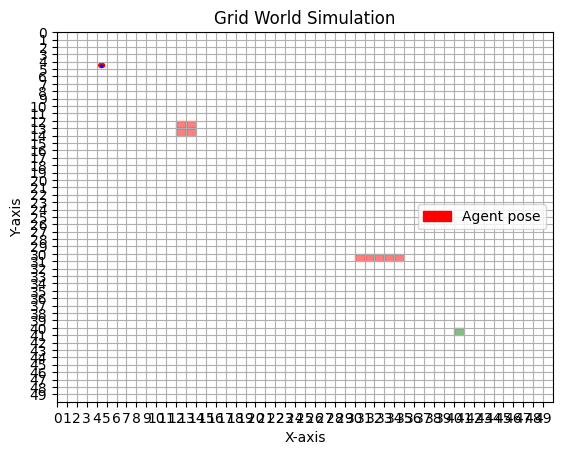

Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240
Iteration 250
Iteration 260
Iteration 270
Iteration 280
Iteration 290
Iteration 300
Iteration 310
Iteration 320
Iteration 330
Iteration 340
Iteration 350
Iteration 360
Iteration 370
Iteration 380
Iteration 390
Iteration 400
Iteration 410
Iteration 420
Iteration 430
Iteration 440
Iteration 450
Iteration 460
Iteration 470
Iteration 480
Iteration 490
Iteration 500
Iteration 510
Iteration 520
Iteration 530
Iteration 540
Iteration 550
Iteration 560
Iteration 570
Iteration 580
Iteration 590
Iteration 600
Iteration 610
Iteration 620
Iteration 630
Iteration 640
Iteration 650
Iteration 660
Iteration 670
Iteration 680
Iteration 690
Iteration 700
Iteration 710
Iteration 720
I

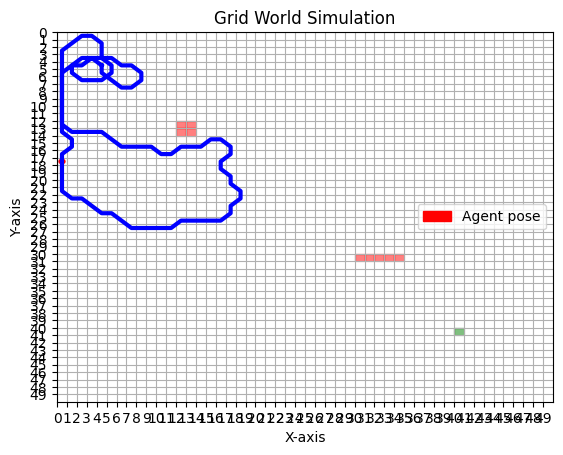

Iteration 1010
Iteration 1020
Iteration 1030
Iteration 1040
Iteration 1050
Iteration 1060
Iteration 1070
Iteration 1080
Iteration 1090
Iteration 1100
Iteration 1110
Iteration 1120
Iteration 1130
Iteration 1140
Iteration 1150
Iteration 1160
Iteration 1170
Iteration 1180
Iteration 1190
Iteration 1200
Iteration 1210
Iteration 1220
Iteration 1230
Iteration 1240
Iteration 1250
Iteration 1260
Iteration 1270
Iteration 1280
Iteration 1290
Iteration 1300
Iteration 1310
Iteration 1320
Iteration 1330
Iteration 1340
Iteration 1350
Iteration 1360
Iteration 1370
Iteration 1380
Iteration 1390
Iteration 1400
Iteration 1410
Iteration 1420
Iteration 1430
Iteration 1440
Iteration 1450
Iteration 1460
Iteration 1470
Iteration 1480
Iteration 1490
Iteration 1500
Iteration 1510
Iteration 1520
Iteration 1530
Iteration 1540
Iteration 1550
Iteration 1560
Iteration 1570
Iteration 1580
Iteration 1590
Iteration 1600
Iteration 1610
Iteration 1620
Iteration 1630
Iteration 1640
Iteration 1650
Iteration 1660
Iteration 

KeyboardInterrupt: 

In [12]:
# SIMULATION
grid_height = 50
grid_width = 50
grid_2d = np.zeros((grid_height, grid_width))

# obstacles
# grid_2d[12:14, 12:14] = 1
obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
for obstacle in obstacles:
    grid_2d[obstacle[0], obstacle[1]] = 1

start_tyx = (0, 4, 4)
goal_tyx = (1,40,40)
grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# MEDIUM simulation
# grid_height = 25
# grid_width = 25
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (1,20,20)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# SMALL simulation
# grid_height = 12
# grid_width = 12
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# # grid_2d[12:14, 12:14] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (3,11,11)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
for i in range(grid_height):
    for j in range(grid_width):
        for k in range(8):
            world_table[k, i, j] = Node(k, i, j)

home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
home.in_gf = True
home.in_gb = True
goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
goal.in_gb = True


agent = Agent(home, goal, world_table)



iteration = 0
max_iterations = 20000
while iteration < max_iterations:
    if iteration % 10 == 0:
        print(f'Iteration {iteration}')
        # print(f'Visible: \n{str(agent.visible_positions)}')
        # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
        # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
        # print(f'agent_trajectory: \n{agent.trajectory}')

    if iteration % 1000 == 0:
        agent.plot_iteration()

    # sample a point to add to GF
    for _ in range(20):
        # success = False
        # while not success:
        coord = agent.sample_for_gf()
        # coord = (0, 8, 10)
        if coord is not None:
            success = agent.attempt_add_node_to_gf(coord)

    # sample a point to add to GB
    i = 0
    while i < 20 or len(agent.unvisited_gb) <= 0:
        i += 1
        coord, index = agent.sample_for_gb()
        if coord is None:
            continue
        success = agent.attempt_add_node_to_gb(coord, index)
        # if success: print(f'Added to GB: {coord}')

    if not agent.move(grid_2d):
        print(f'Failed to move, iteration: {iteration}')
        break

    assert agent.pose not in obstacles, 'Agent ran into obstacle :('



    if agent.pose == (goal.x, goal.y):
        print(f'Goal reached, iteration: {iteration}')
        print(f'agent_trajectory: \n{agent.trajectory}')
        break

    iteration += 1
    # time.sleep(0.01)
if iteration == max_iterations:
    print('Max iterations reached :(')
print(f'DONE: Iteration: {iteration}')
